In [51]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [52]:
raw=mne.io.read_raw_gdf('BCICIV_2a_gdf/A01E.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from D:\bci project\BCI PROJECT-20220624T090242Z-001\BCI PROJECT\Notebooks\BCI 4\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\hp\appdata\local\programs\python\python39\lib\contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 22 x 687000 (2748.0 s), ~26 kB, data not loaded>

From the paper:-
'1023': 1 (Rejected trial),
'1072': 2 (Eye movements),
'276': 3 (eyes open)),
'277': 4 (eyes closed),
'32766':5 (Start of a new run),
'768': 6 (Start of a trial),
'769': 7 (class 1),
'770': 8 (class 2),
'771': 9 (class 3),
'772': 10 (class 4)
event ids are not same for all subjects

In [53]:
 def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events, event_id =mne.events_from_annotations(raw)
    #events[1]['769'],events[1]['770'],events[1]['771'],events[1]['772']
    ann = event_id.keys()
    ann = list(map(int,ann))
    ids = event_id.values()
    ids = list(ids)
    unq = np.unique(events[:,-1])
    for u in unq:
        events[:,-1] = np.where(events[:,-1]== u , ann[u-1],events[:,-1])
    epochs = mne.Epochs(raw, events, event_id=[770,771],
                        tmin= 0, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [54]:
paths = glob.glob('BCICIV_2a_gdf/*T.gdf')
paths

['BCICIV_2a_gdf\\A01T.gdf',
 'BCICIV_2a_gdf\\A02T.gdf',
 'BCICIV_2a_gdf\\A03T.gdf',
 'BCICIV_2a_gdf\\A04T.gdf',
 'BCICIV_2a_gdf\\A05T.gdf',
 'BCICIV_2a_gdf\\A06T.gdf',
 'BCICIV_2a_gdf\\A07T.gdf',
 'BCICIV_2a_gdf\\A08T.gdf',
 'BCICIV_2a_gdf\\A09T.gdf']

In [55]:
%%capture
features,labels,groups=[],[],[]
for i in paths:
    feature,label=read_data(i)
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [56]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((1296, 22, 1001), (1296,), (1296,))

In [57]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array(['BCICIV_2a_gdf\\A01T.gdf', 'BCICIV_2a_gdf\\A02T.gdf',
        'BCICIV_2a_gdf\\A03T.gdf', 'BCICIV_2a_gdf\\A04T.gdf',
        'BCICIV_2a_gdf\\A05T.gdf', 'BCICIV_2a_gdf\\A06T.gdf',
        'BCICIV_2a_gdf\\A07T.gdf', 'BCICIV_2a_gdf\\A08T.gdf',
        'BCICIV_2a_gdf\\A09T.gdf'], dtype='<U22'),
 array([144, 144, 144, 144, 144, 144, 144, 144, 144], dtype=int64))

# Chronet tensor preparation

In [58]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [59]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [60]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
labels =  lb.fit_transform(labels)

In [61]:
np.unique(labels)

array([0, 1])

In [62]:
data_array = features
label_array = labels
group_array = groups
#data_array=np.moveaxis(data_array,1,2)

In [63]:
accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler3D()
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)
    break

In [64]:
scaler=StandardScaler3D()
train_features,val_features,train_labels,val_labels = train_test_split(data_array, label_array, test_size=0.25, random_state=2)
train_features=scaler.fit_transform(train_features)
val_features=scaler.transform(val_features)

In [65]:
train_features.shape, train_labels.shape

((972, 22, 1001), (972, 1))

# DeepConvNet

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf

In [67]:
def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('sigmoid')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [68]:
deepconvnet = DeepConvNet(1, features.shape[1],features.shape[2],dropoutRate = 0.2)
deepconvnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 22, 1001, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 22, 997, 25)       150       
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 997, 25)        13775     
                                                                 
 batch_normalization_8 (Batc  (None, 1, 997, 25)       100       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 1, 997, 25)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 498, 25)       0         
 2D)                                                       

In [69]:
deepconvnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss = 'binary_crossentropy',metrics=['accuracy'])

In [70]:
deepconvnet_history = deepconvnet.fit(train_features, train_labels,epochs=50,batch_size=32,validation_data=(val_features, val_labels))

Epoch 1/50
31/31 [==============================] - 16s 422ms/step - loss: 1.0495 - accuracy: 0.6111 - val_loss: 0.9117 - val_accuracy: 0.6512
Epoch 2/50
31/31 [==============================] - 11s 361ms/step - loss: 0.7932 - accuracy: 0.6687 - val_loss: 0.9313 - val_accuracy: 0.6698
Epoch 3/50
31/31 [==============================] - 11s 364ms/step - loss: 0.6773 - accuracy: 0.7202 - val_loss: 0.9063 - val_accuracy: 0.6389
Epoch 4/50
31/31 [==============================] - 12s 402ms/step - loss: 0.5764 - accuracy: 0.7315 - val_loss: 0.5003 - val_accuracy: 0.7531
Epoch 5/50
31/31 [==============================] - 13s 419ms/step - loss: 0.5728 - accuracy: 0.7479 - val_loss: 0.5311 - val_accuracy: 0.7469
Epoch 6/50
31/31 [==============================] - 12s 388ms/step - loss: 0.4960 - accuracy: 0.7706 - val_loss: 0.5474 - val_accuracy: 0.7562
Epoch 7/50
31/31 [==============================] - 12s 396ms/step - loss: 0.4674 - accuracy: 0.7891 - val_loss: 0.4674 - val_accuracy: 0.7994

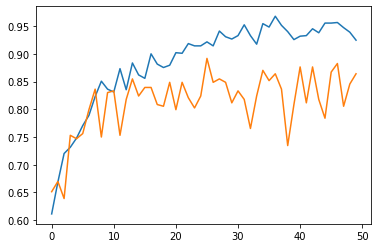

In [71]:
plt.plot(deepconvnet_history.history["accuracy"])
plt.plot(deepconvnet_history.history["val_accuracy"])

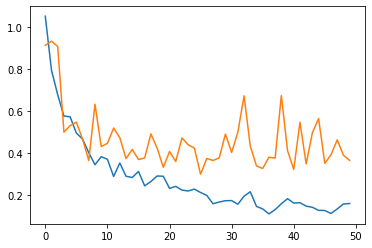

In [72]:
plt.plot(deepconvnet_history.history["loss"])
plt.plot(deepconvnet_history.history["val_loss"])

#Binary Class Class accuaracies

In [73]:
model = deepconvnet

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       475
           1       1.00      0.95      0.97       497

    accuracy                           0.97       972
   macro avg       0.97      0.97      0.97       972
weighted avg       0.97      0.97      0.97       972



<AxesSubplot:>

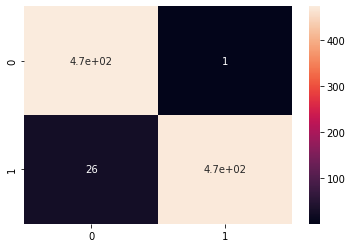

In [74]:
# classification report on training set
y_p = []
pred = model.predict_on_batch(train_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = train_labels.reshape(train_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       173
           1       0.90      0.80      0.85       151

    accuracy                           0.86       324
   macro avg       0.87      0.86      0.86       324
weighted avg       0.87      0.86      0.86       324



<AxesSubplot:>

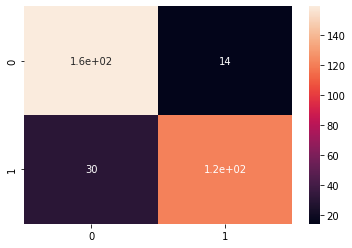

In [75]:
# classification report on validation set
y_p = []
pred = model.predict_on_batch(val_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = val_labels.reshape(val_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

#Multiclass class accuracies 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324



<AxesSubplot:>

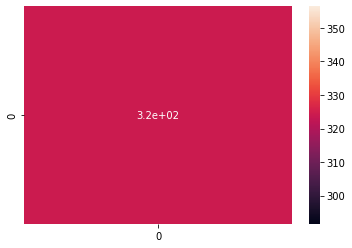

In [76]:
y_t = np.argmax(val_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(val_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       972

    accuracy                           1.00       972
   macro avg       1.00      1.00      1.00       972
weighted avg       1.00      1.00      1.00       972



<AxesSubplot:>

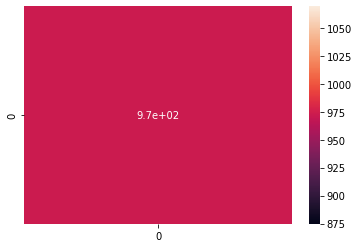

In [77]:
y_t = np.argmax(train_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(train_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

In [78]:
y_p = model.predict_on_batch(val_features)

In [79]:
np.count_nonzero(val_labels)

151

In [80]:
len(val_labels)

324